# Document Extraction

In this notebook, we will demonstrate how to utilize textract to extract text, table's, forms from documents. We will also showcase how to use the Analyze ID and Analyze Expense API's

Additional code samples and methods of wrangling textract api response JSON's can be found [here](https://github.com/aws-samples/amazon-textract-code-samples/blob/master/python/Textract.ipynb) - pay particular attention to Section 8, 10 and 12. 

We are first going to install the following python libraries: 

- [Amazon Textract Response Parser](https://github.com/aws-samples/amazon-textract-response-parser/blob/master/src-python/README.md)
- [tabulate](https://pypi.org/project/tabulate/)
- [Amazon Textract Pretty Printer](https://github.com/aws-samples/amazon-textract-textractor/tree/master/prettyprinter)
- [Amazon Textract Caller](https://github.com/aws-samples/amazon-textract-textractor/tree/master/caller)

Throughout this notebook, we will use utilise the libraries in a few different ways - this is simply to showcase the versatility of the tools available to you when handle JSON output from the textract API.

In [1]:
!pip install amazon-textract-response-parser tabulate amazon-textract-prettyprinter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


`amazon-textract-caller`

Let's now import some additional libraries.

In [9]:
#import our libararies
import boto3
import json
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint
import trp #textract response parser library
from tabulate import tabulate

from IPython.display import Image, display, IFrame
from PIL import Image as PImage, ImageDraw
from textractprettyprinter.t_pretty_print_expense import get_string, Textract_Expense_Pretty_Print, Pretty_Print_Table_Format
# from textractcaller.t_call import call_textract, Textract_Features
from textractprettyprinter.t_pretty_print import Textract_Pretty_Print, get_string

Below is an example function that we are constructing using the Textract response parser - this functions shows how to:

- iterate through distinct **pages** in the textract JSON response
- how to select the **form** construct from the pages
- how to select the identified **keys** and **values** from the forms

In [10]:
# #Helper Function for Form Extraction
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

We will now upload the sample documents that are in the `./dataset/document_extraction/` folder to S3.

S3 will serve as the starting point for our txtract extractions - identical to how textract would be employed in production workloads.

In [11]:
mySession = boto3.session.Session()
awsRegion = mySession.region_name
data_bucket = sagemaker.Session().default_bucket()

# Amazon S3 client
s3 = boto3.client('s3')

# Amazon Textract client
textract = boto3.client('textract')

In [13]:
#upload to S3
key='idp/textract/cms1500.png'
s3.upload_file(Filename='./dataset/document_samples/CMS1500.png', 
               Bucket=data_bucket, 
               Key=key)

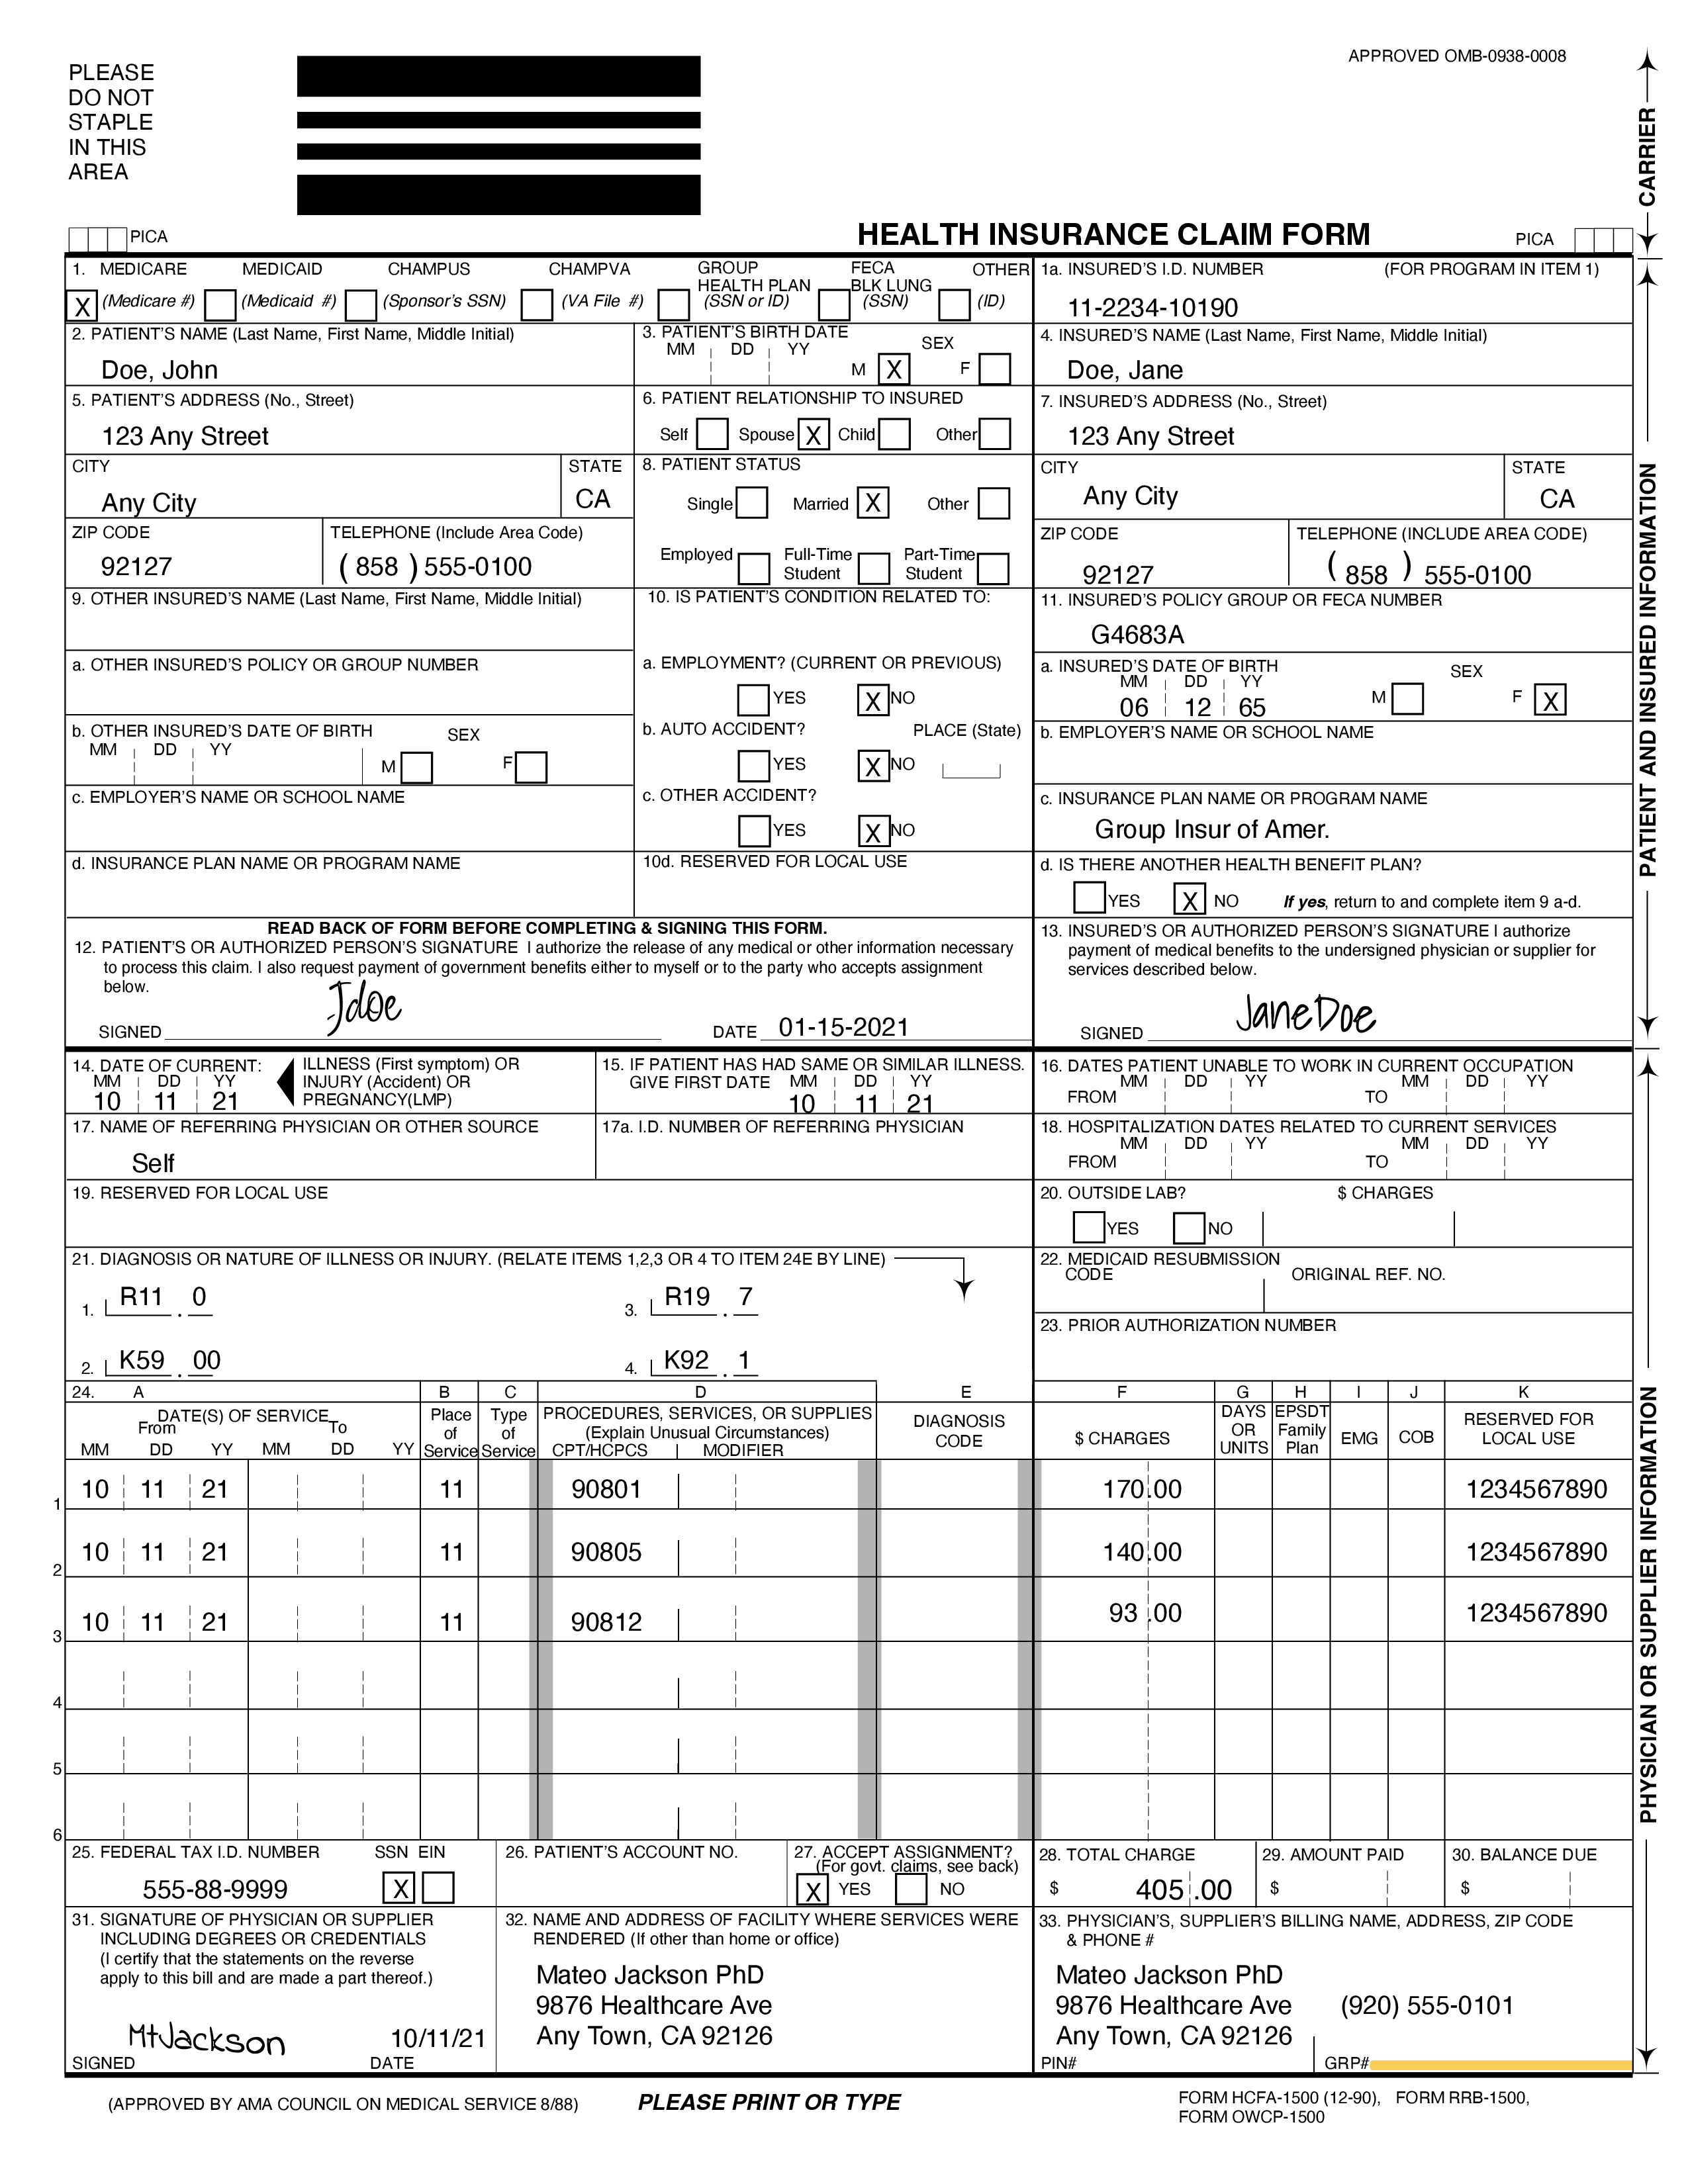

In [14]:
display(Image(filename="./dataset/document_samples/CMS1500.png", width=900, height=400))

We will now use textract to extract both the **FORMS** and the **TABLES** from the CMS1500 document.

In [16]:
form_resp = textract.analyze_document(Document={'S3Object':{"Bucket": data_bucket, "Name": key}
    }, FeatureTypes=['FORMS', 'TABLES']
)

print(get_string(textract_json=form_resp, output_type=[Textract_Pretty_Print.TABLES], table_format=Pretty_Print_Table_Format.fancy_grid))


╒═══╤═════╤═════════╤═══════════════╤════════════╤═══════╤════╤══════════════════╤═════════════════╤════════════════════════════════════════╤═══════════╤═════════════════════════════════════╤════════════════╕
│   │ 24. │ A       │               │            │       │    │ B                │ C               │                                        │ D         │                                     │ E              │
├───┼─────┼─────────┼───────────────┼────────────┼───────┼────┼──────────────────┼─────────────────┼────────────────────────────────────────┼───────────┼─────────────────────────────────────┼────────────────┤
│   │ MM  │ From DD │ DATE(S) OF YY │ SERVICE MM │ To DD │ YY │ Place of Service │ Type of Service │ PROCEDURES, (Explain Unusual CPT/HCPCS │ SERVICES, │ OR SUPPLIES Circumstances) MODIFIER │ DIAGNOSIS CODE │
├───┼─────┼─────────┼───────────────┼────────────┼───────┼────┼──────────────────┼─────────────────┼────────────────────────────────────────┼───────────┼───────────

In [15]:
print(get_string(textract_json=form_resp, output_type=[Textract_Pretty_Print.FORMS], table_format=Pretty_Print_Table_Format.fancy_grid))

╒═════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════╕
│ Key                                                             │ Value                                                             │
├─────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ PICA                                                            │ NOT_SELECTED                                                      │
├─────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ PICA                                                            │ NOT_SELECTED                                                      │
├─────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ MEDICARE (Medicare #)                         

Let's now look at the **Analyze ID** API.

In [15]:
#upload to S3
key='idp/textract/drivers_license.png'
s3.upload_file(Filename='./dataset/document_samples/drivers_license.png', 
               Bucket=data_bucket, 
               Key=key)

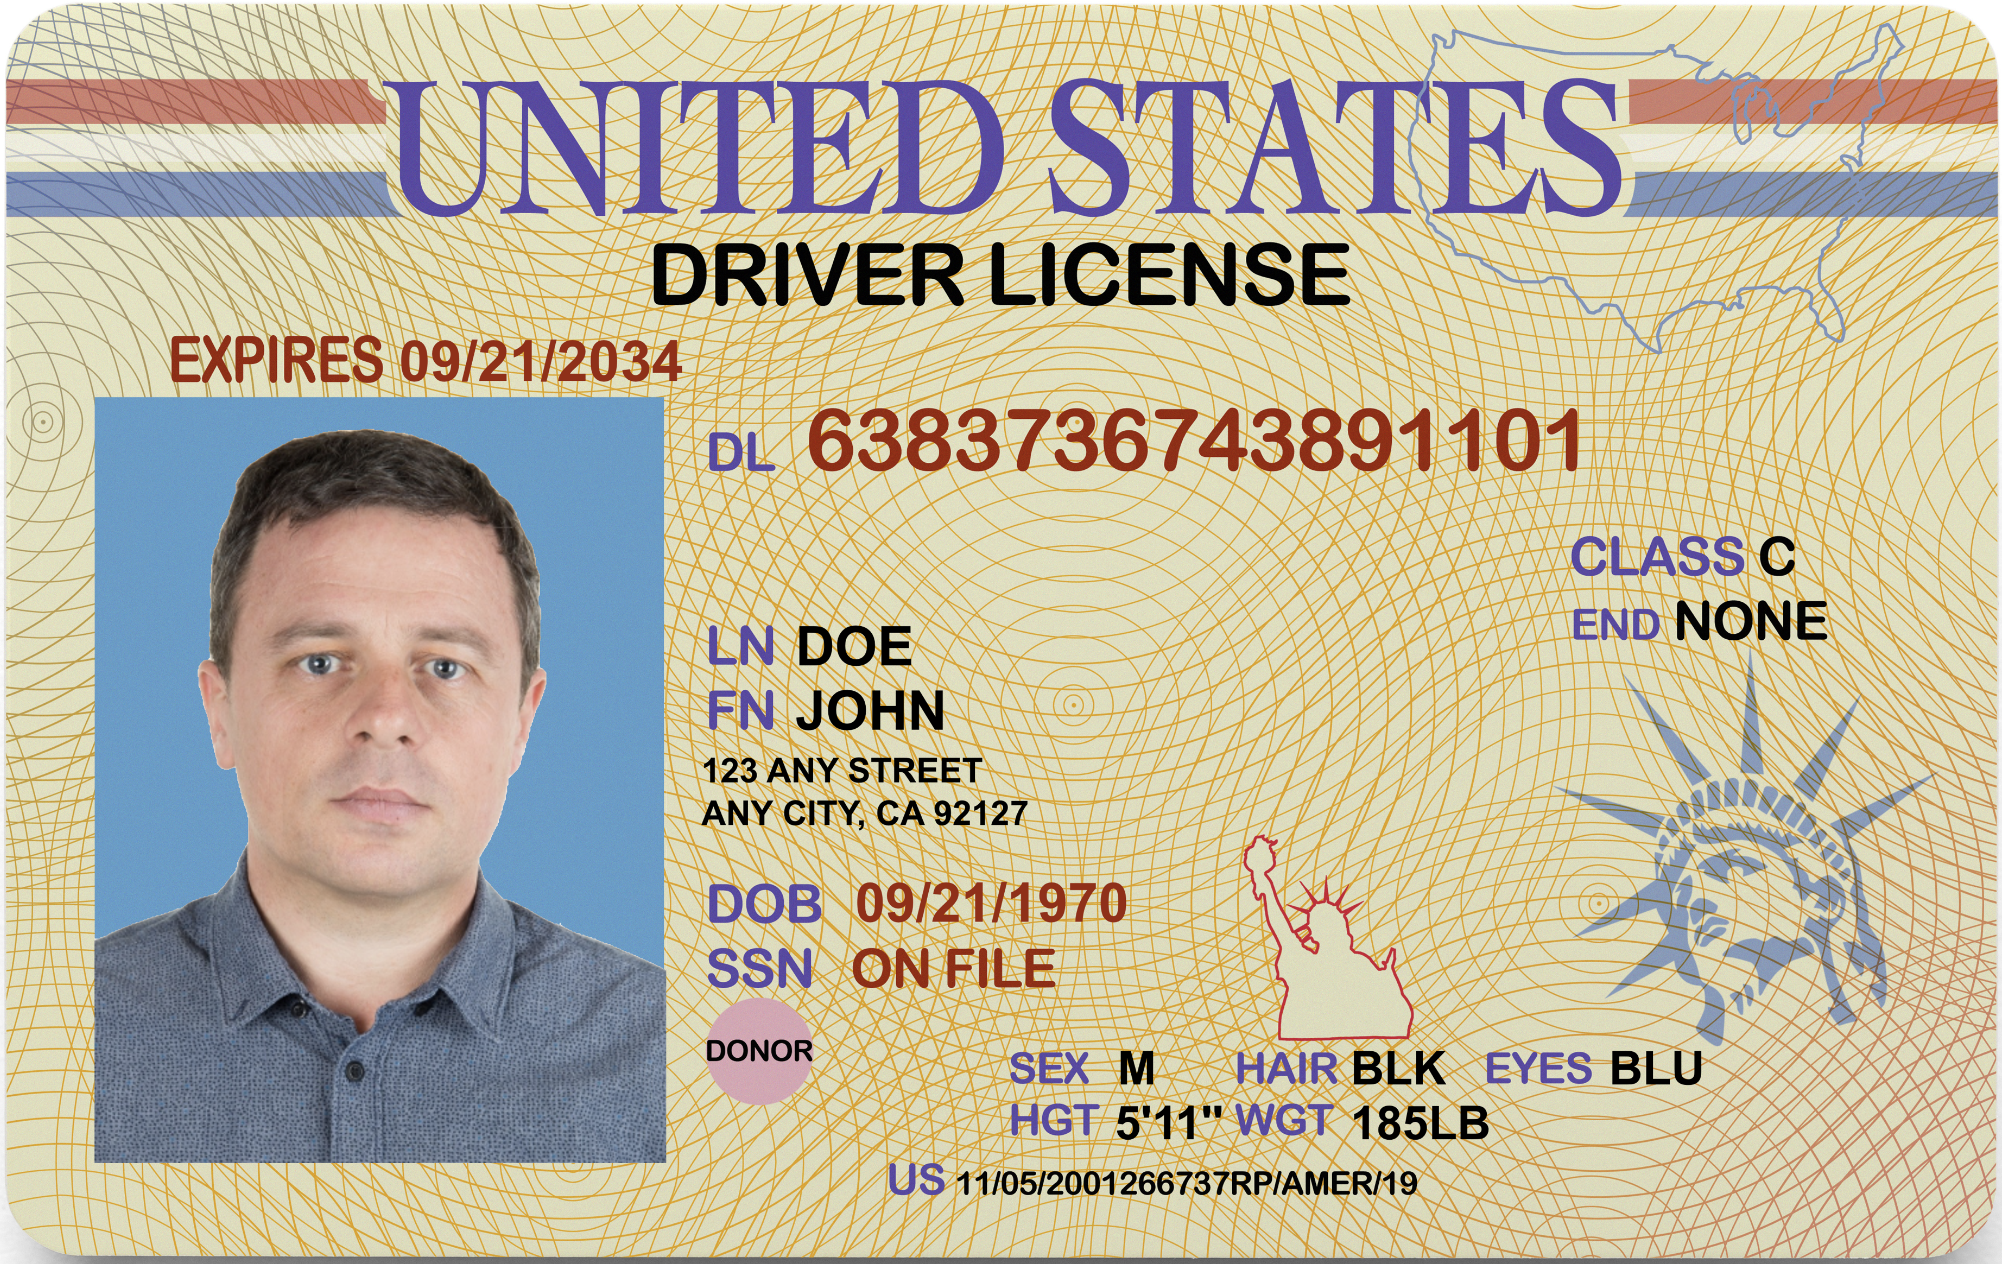

In [16]:
display(Image(filename="./dataset/document_samples/drivers_license.png", width=900, height=400))

In [22]:
ID_resp = textract.analyze_id(DocumentPages=[{'S3Object':{"Bucket": data_bucket, "Name": key}}])

In [23]:
#once again using the textract response parser
from trp.trp2_analyzeid import TAnalyzeIdDocument, TAnalyzeIdDocumentSchema
t_doc = TAnalyzeIdDocumentSchema().load(ID_resp)

From below, you will notice certain key's are presented that were **not** in the driver's license itself.

For example, **Veteran** is not a key found in the license, however, it is a pre-populated key value that Analyze ID supports, due to the differences found amongst licenses between states.

In [25]:
list_of_results = t_doc.get_values_as_list()
print(tabulate([x[1:3] for x in list_of_results]))

-------------------  --------------------
FIRST_NAME           JOHN
LAST_NAME            DOE
MIDDLE_NAME
SUFFIX
CITY_IN_ADDRESS      ANY CITY
ZIP_CODE_IN_ADDRESS  92127
STATE_IN_ADDRESS     CA
STATE_NAME           CALIFORNIA
DOCUMENT_NUMBER      6383736743891101
EXPIRATION_DATE      09/21/2034
DATE_OF_BIRTH        09/21/1970
DATE_OF_ISSUE
ID_TYPE              DRIVER LICENSE FRONT
ENDORSEMENTS         NONE
VETERAN
RESTRICTIONS
CLASS                C
ADDRESS              123 ANY STREET
COUNTY
PLACE_OF_BIRTH
-------------------  --------------------


Let's now take a look at an example medical insurance card and extract the 'form' from it.

In [17]:
#upload to S3
key='idp/textract/insurance_card.png'
s3.upload_file(Filename='./dataset/document_samples/insurance_card.png', 
               Bucket=data_bucket, 
               Key=key)

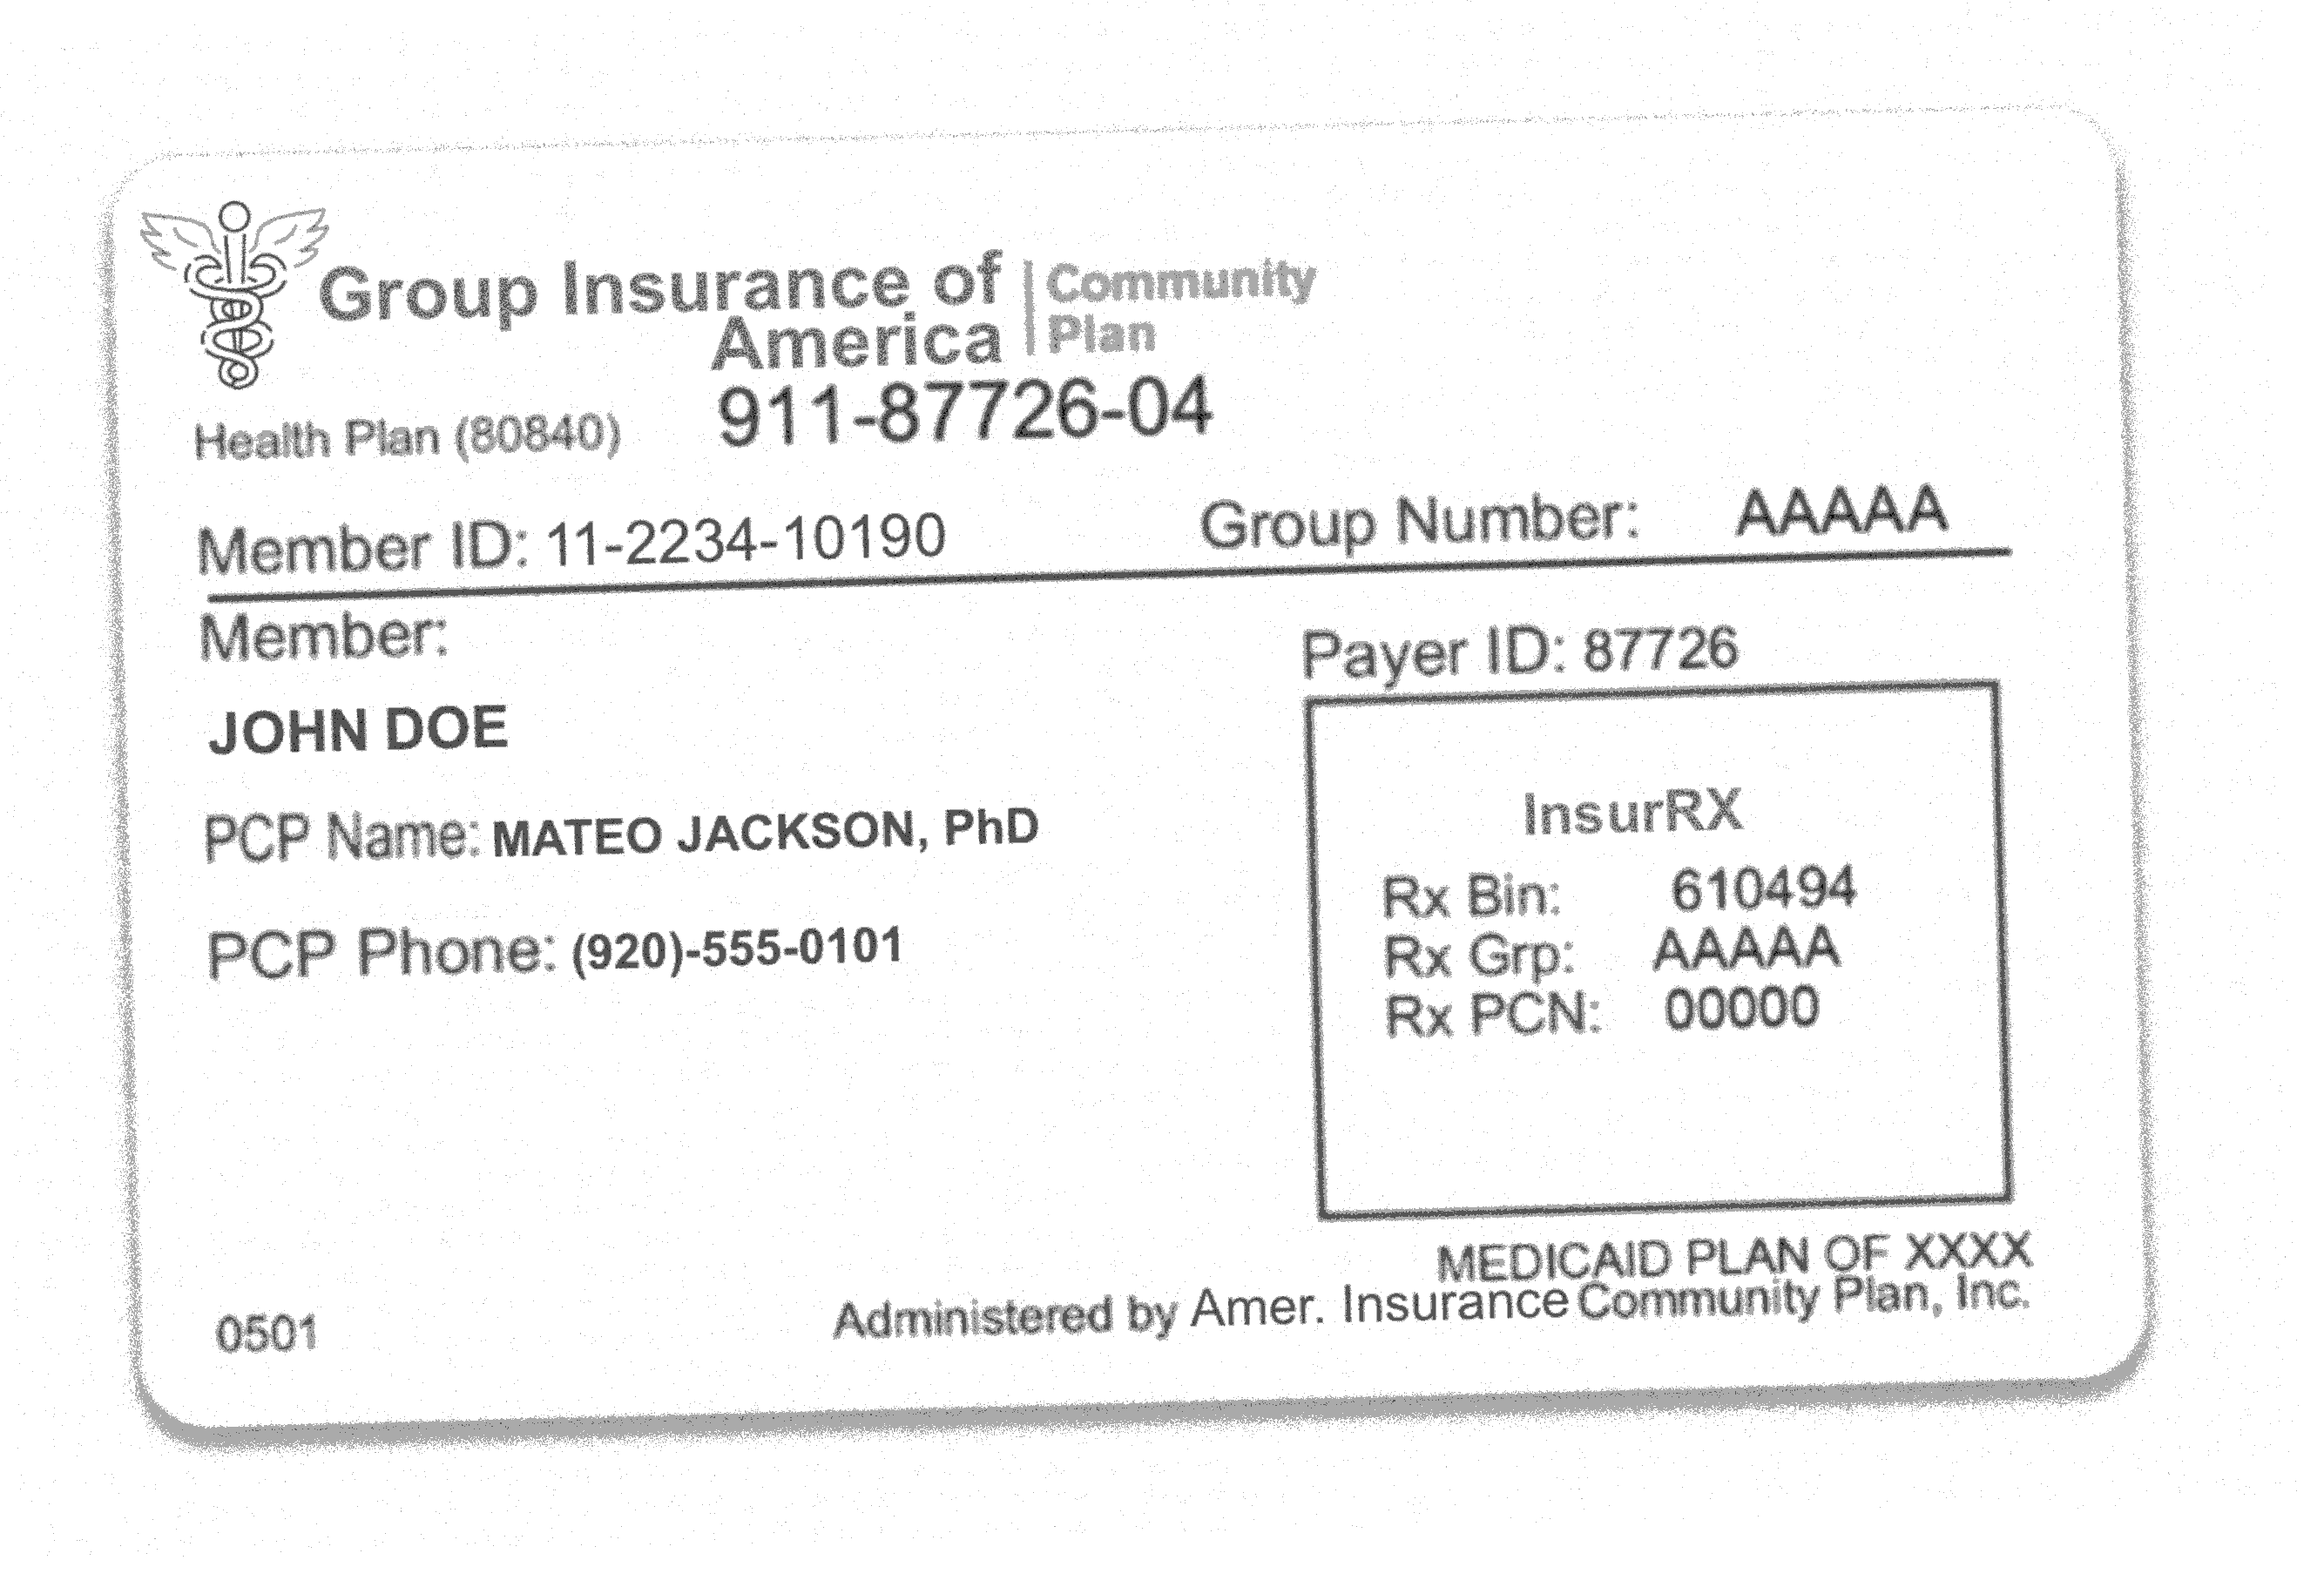

In [18]:
display(Image(filename="./dataset/document_samples/insurance_card.png", width=900, height=400))

In [28]:
form_resp = textract.analyze_document(Document={'S3Object':{"Bucket": data_bucket, "Name": key}
    }, FeatureTypes=['FORMS']
)

In [30]:
# using our constructed helper function - values returned as a dictionary
getformkeyvalue(form_resp)

{'Group Number:': 'AAAAA',
 'PCP Phone:': '(920)-555-0101',
 'PCP Name:': 'MATEO JACKSON, PhD',
 'Rx PCN:': '00000',
 'Rx Bin:': '610494',
 'Rx Grp:': 'AAAAA',
 'Payer ID:': '87726',
 'Member ID:': '11-2234-10190',
 'Member:': 'JOHN DOE',
 'Administered by Amer.': 'Insurance Community Plan, Inc.',
 'Health Plan': '911-87726-04'}

Let's now look at the **Analyze Expense** API to extract information from a medical insurance invoice.

In [31]:
#upload to S3
key='idp/textract/insurance_invoice.png'
s3.upload_file(Filename='./dataset/document_extraction/insurance_invoice.png', 
               Bucket=data_bucket, 
               Key=key)

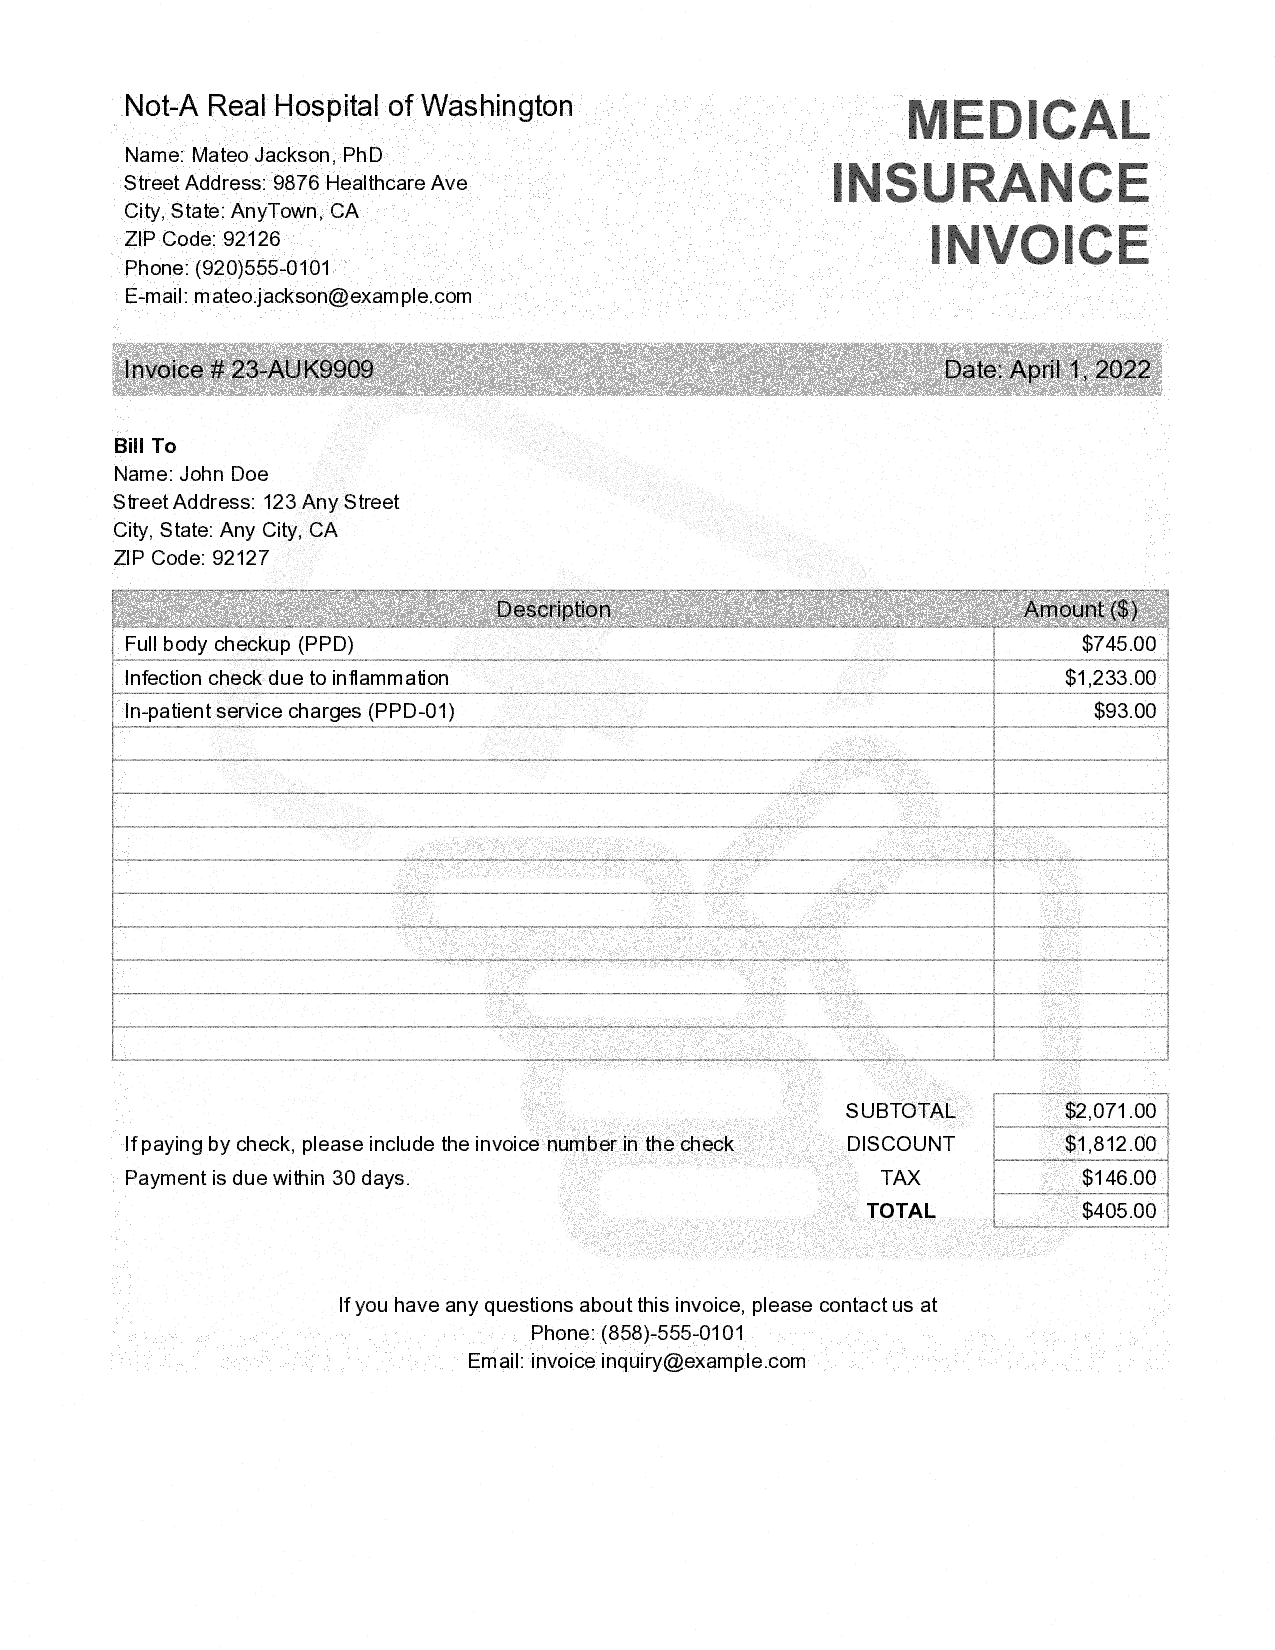

In [19]:
display(Image(filename="./dataset/document_samples/insurance_invoice.png", width=900, height=400))

From the below, it is important to notice that textract provides the ability to seperately extract the "line items" from the overall invoice.

In [33]:
expense_resp = textract.analyze_expense(Document={'S3Object':{"Bucket": data_bucket, "Name": key}})

In [222]:
print(get_string(textract_json=ID_resp, output_type=[Textract_Expense_Pretty_Print.SUMMARY, Textract_Expense_Pretty_Print.LINEITEMGROUPS], table_format=Pretty_Print_Table_Format.fancy_grid))


╒═══════════════════════════════╤════════════════════════════════╕
│ Key                           │ Value                          │
├───────────────────────────────┼────────────────────────────────┤
│ Street Address:(OTHER)        │ 123 Any Street                 │
├───────────────────────────────┼────────────────────────────────┤
│ ZIP Code:(OTHER)              │ 92127                          │
├───────────────────────────────┼────────────────────────────────┤
│ Name:(OTHER)                  │ John Doe                       │
├───────────────────────────────┼────────────────────────────────┤
│ É-mail:(OTHER)                │ mateo.jackson@example.com      │
├───────────────────────────────┼────────────────────────────────┤
│ Phone:(OTHER)                 │ (920)555-0101                  │
├───────────────────────────────┼────────────────────────────────┤
│ City, State:(OTHER)           │ Any City, CA                   │
├───────────────────────────────┼─────────────────────────────

 
# Conclusion

In this notebook, we saw how to extract `FORMS, TABLES, and TEXT` lines from various document types that may be present in a claims processing packet. We also used Amazon Textract AnalyzeID to detect information from passport document. We also used Textract to extract specific information out of a document which is dense text and got accurate responses back from the API. In the next notebook, we will perform enrichment on one of the documents.